In [1]:
%matplotlib inline
from utils import *
from sklearn.model_selection import train_test_split
import pickle
from icnet import build_bn
import matplotlib.pyplot as plt

PATH = '/workspace/datasets/OpenSourceDatasets/VOCdevkit/VOC2012/'
image_size = (376, 672)
#image_size = (256, 256)

bs = 4
NET = 'deeplab_wisense'

Using TensorFlow backend.


In [2]:
SegClass = SegModel(PATH, image_size, use_coords = False)
SegClass.set_batch_size(bs)
SegClass.set_num_epochs(30)

opt = SGD(lr = .005, momentum=0.3)

model = Deeplabv3(weights=None, input_tensor=None, infer = False,
                  input_shape = image_size + (3,), classes=21, 
                  backbone='mobilenetv2', OS=16, alpha=1, use_coordconv = False)

model.load_weights('weights/deeplab_376061.h5')

## Fine tune to lower number of classes

In [3]:
x = Conv2D(MAX_CLASSES, (1, 1), padding='same', name='custom_logits_semantic')(model.layers[-5].output)
x = Lambda(lambda x: tf.image.resize_bilinear(x,size=(image_size[0],image_size[1])))(x)
x = Reshape((image_size[0]*image_size[1], MAX_CLASSES))(x)
x = Activation('softmax')(x)
model = Model(model.input, x, name='deeplabv3p_wisense')

model.compile(optimizer = opt, sample_weight_mode = "temporal",
              loss = 'categorical_crossentropy',
              metrics = [Jaccard, background_accuracy, 
                         accuracy_ignoring_last_label,
                         foreground_accuracy])

SegClass.net = NET + '_' + str(image_size[0])
n_classes = len(get_VOC2012_classes()) - 1
SegClass.n_classes = n_classes
SegClass.modelpath = 'weights/'+SegClass.net+'{epoch:03d}.h5'

In [5]:
train_generator = SegClass.create_generators(resize_shape = tuple(reversed(image_size)), blur = 5,
                                             crop_shape = False, mode = 'train',n_classes = MAX_CLASSES, 
                                             horizontal_flip = True, vertical_flip = False, 
                                             icnet = NET == 'icnet',brightness=0.3, rotation=2.0, 
                                             zoom=0.1, validation_split = .2, seed = 7, do_ahisteq = True)

valid_generator = SegClass.create_generators(resize_shape = tuple(reversed(image_size)),
                                             crop_shape = False, mode = 'validation', n_classes = MAX_CLASSES, 
                                             horizontal_flip = True, vertical_flip = False, 
                                             icnet = NET == 'icnet',brightness=.1, rotation=False, 
                                             zoom=.05, validation_split = .2, seed = 7, do_ahisteq = True)

In [6]:
def build_callbacks(tf_board = False, plot_process = True, steps = 50):
    tensorboard = TensorBoard(log_dir='./logs/'+SegClass.net, histogram_freq=0,
                        write_graph=False, write_images = False)
    checkpointer = ModelCheckpoint(filepath = SegClass.modelpath, verbose=1, save_best_only=True, save_weights_only=True,
                                    monitor = 'val_Jaccard', mode = 'max')
    stop_train = EarlyStopping(monitor = 'val_Jaccard', patience=100, verbose=1, mode = 'max')
    reduce_lr = ReduceLROnPlateau(monitor = 'val_Jaccard', factor=0.5,
                patience=3, min_lr=1e-6)
    if plot_process:
        callbacks = [checkpointer, reduce_lr, stop_train, tensorboard, PlotLearning()]
    elif tf_board:
        callbacks = [checkpointer, reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks

In [ ]:
steps = len(train_generator)
callbacks = build_callbacks(tf_board = True, plot_process = False, steps=steps//2)

h = model.fit_generator(train_generator, class_weight = None,
                        steps_per_epoch=steps, 
                        epochs = 20, verbose=1, 
                        callbacks = callbacks, initial_epoch = 0,
                        validation_data=valid_generator,
                        validation_steps=len(valid_generator), 
                        max_queue_size=10, 
                        workers=workers, use_multiprocessing=True)

Epoch 4/20
2406/2406 [==============================] - 1259s 523ms/step - loss: 0.0470 - Jaccard: 0.7086 - background_accuracy: 0.9271 - accuracy_ignoring_last_label: 0.9324 - foreground_accuracy: 0.8686 - val_loss: 0.0963 - val_Jaccard: 0.6925 - val_background_accuracy: 0.9100 - val_accuracy_ignoring_last_label: 0.9129 - val_foreground_accuracy: 0.8415

Epoch 00004: val_Jaccard improved from -inf to 0.69250, saving model to weights/deeplab_wisense_376004.h5
Epoch 5/20
2406/2406 [==============================] - 1192s 496ms/step - loss: 0.0436 - Jaccard: 0.7132 - background_accuracy: 0.9298 - accuracy_ignoring_last_label: 0.9353 - foreground_accuracy: 0.8858 - val_loss: 0.1016 - val_Jaccard: 0.6962 - val_background_accuracy: 0.9197 - val_accuracy_ignoring_last_label: 0.9199 - val_foreground_accuracy: 0.8252

Epoch 00005: val_Jaccard improved from 0.69250 to 0.69617, saving model to weights/deeplab_wisense_376005.h5
Epoch 6/20
2406/2406 [==============================] - 1200s 499ms/s

## Train normally

In [ ]:
h = SegClass.train_generator(model, train_generator = train_generator,
                             valid_generator = valid_generator, plot_test_images = False,
                             tf_board = True, mp = True)

In [52]:
K.sum(tf.to_float(~legal_labels)) + .01

<tf.Tensor 'add_2:0' shape=() dtype=float32>

In [50]:
sess = tf.Session()
sess.run(K.sum(tf.to_float(~legal_labels)) + 1)

151412.0

In [46]:
    nb_classes = K.int_shape(y_pred)[-1]
    y_pred = K.reshape(y_pred, (-1, nb_classes))
    y_true = K.reshape(y_true, (-1, nb_classes))
    pred_pixels = K.argmax(y_pred, axis=-1)
    true_pixels = K.argmax(y_true, axis=-1)
    unpacked = tf.unstack(y_true, axis=-1)
    legal_labels = tf.cast(unpacked[0], tf.bool) | ~K.greater(K.sum(y_true, axis=-1), 0)


In [21]:
    nb_classes = K.int_shape(y_pred)[-1]
    y_pred = K.reshape(y_pred, (-1, nb_classes))
    y_true = K.reshape(y_true, (-1, nb_classes))
    pred_pixels = K.argmax(y_pred, axis=-1)
    true_pixels = K.argmax(y_true, axis=-1)
    unpacked = tf.unstack(y_true, axis=-1)
    legal_labels = tf.cast(unpacked[0], tf.bool) | ~K.greater(K.sum(y_true, axis=-1), 0)


ValueError: Invalid reduction dimension 1 for input with 1 dimensions. for 'Sum_9' (op: 'Sum') with input shapes: [1010688], [] and with computed input tensors: input[1] = <1>.

In [ ]:
def Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(1, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.to_int32(true_labels & pred_labels)
        union = tf.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.to_int32(true_labels), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.debugging.is_nan(iou)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)


In [ ]:
def foreground_accuracy(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    y_pred = K.reshape(y_pred, (-1, nb_classes))
    y_true = K.reshape(y_true, (-1, nb_classes))
    pred_pixels = K.argmax(y_pred, axis=-1)
    true_pixels = K.argmax(y_true, axis=-1)
    unpacked = tf.unstack(y_true, axis=-1)
    legal_labels = tf.cast(unpacked[0], tf.bool) | ~K.greater(K.sum(y_true, axis=-1), 0)
    return K.sum(tf.to_float(~legal_labels & K.equal(true_pixels, pred_pixels))) / K.sum(tf.to_float(~legal_labels))


In [10]:
pred = model.predict(x)

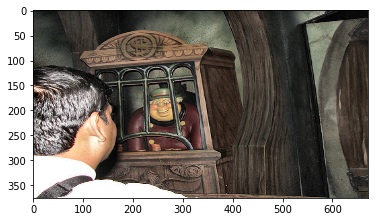

In [5]:
X = x[0][0].astype('uint8')
y = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
plt.imshow(y)

In [29]:
X = x[0][0].astype('uint8')

#X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
img_yuv = cv2.cvtColor(X, cv2.COLOR_BGR2YUV)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)


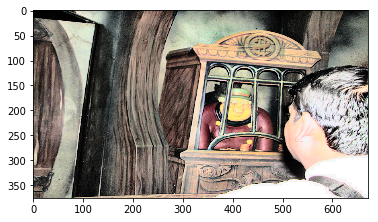

In [30]:
plt.imshow(img_output)

In [7]:
model.predict(x)

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [6]:
x,y,s = next(iter(train_generator))

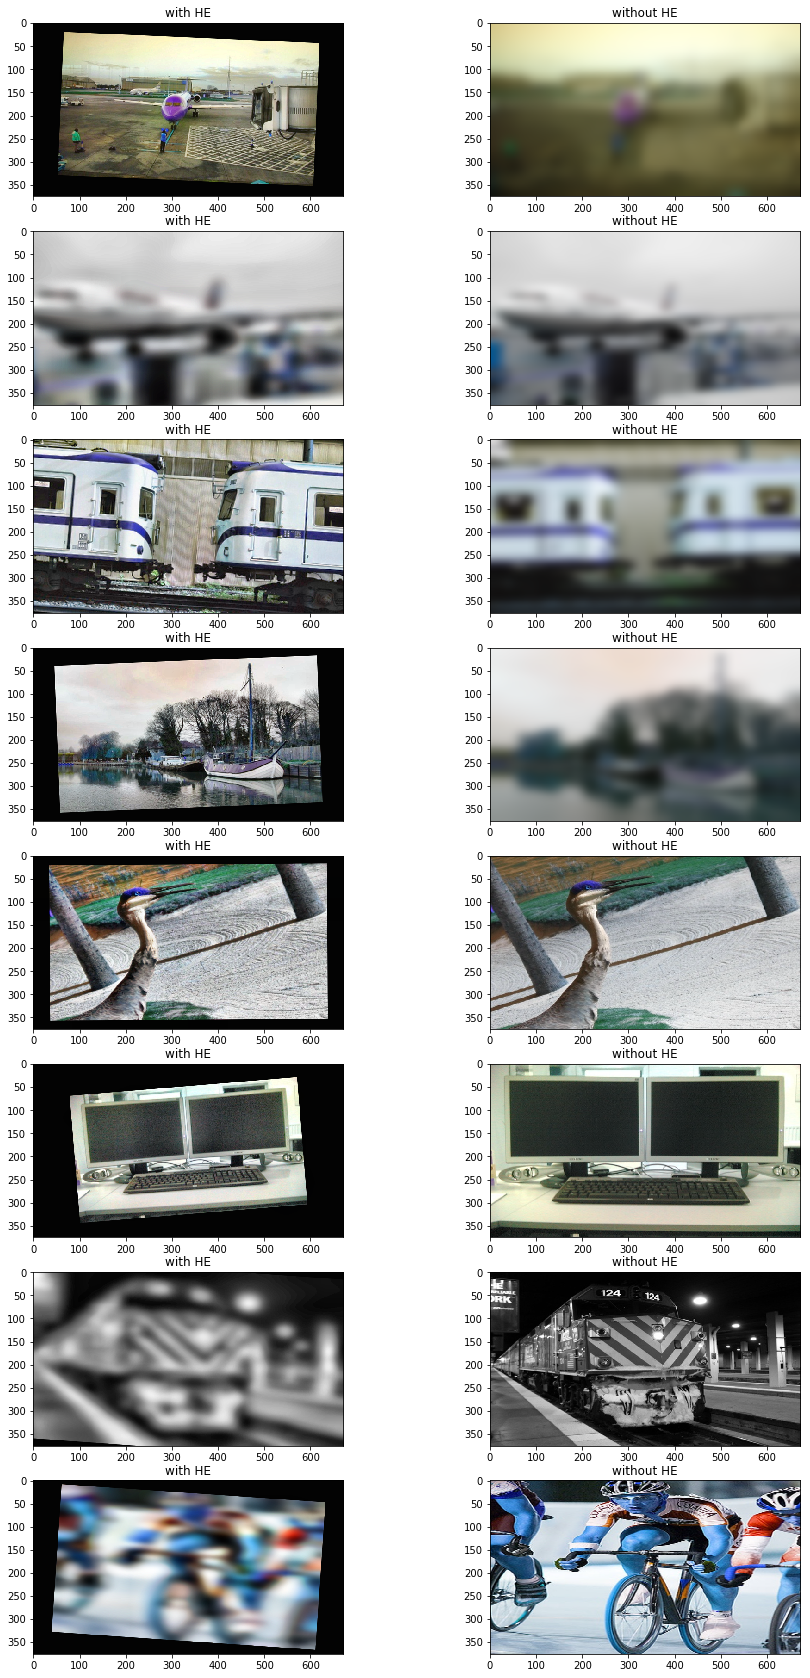

In [9]:
train_generator1 = SegClass.create_generators(resize_shape = tuple(reversed(image_size)), blur = 55,
                                             crop_shape = False, mode = 'train',n_classes = 21, 
                                             horizontal_flip = False, vertical_flip = False, 
                                             icnet = NET == 'icnet',brightness=0.3, rotation=5, 
                                             zoom=.2, validation_split = .2, seed = 7, do_ahisteq = True)

train_generator2 = SegClass.create_generators(resize_shape = tuple(reversed(image_size)), blur = 55,
                                             crop_shape = False, mode = 'train',n_classes = 21, 
                                             horizontal_flip = False, vertical_flip = False, 
                                             icnet = NET == 'icnet',brightness=0, rotation=0, 
                                             zoom=0, validation_split = .2, seed = 7, do_ahisteq = False)


x,_,_ = next(iter(train_generator1))
x2,_,_ = next(iter(train_generator2))

preds = model.predict(x)
preds2 = model.predict(x2)

preds = np.argmax(preds, axis=-1)
preds2 = np.argmax(preds2, axis=-1)

mask = np.reshape(preds, (bs,) + image_size)
mask2 = np.reshape(preds2, (bs,) + image_size)

plt.figure(figsize=(15,30))

for i in range(bs):
    ind = i+1
    plt.subplot(8, 2, 2*ind-1)
    plt.imshow(x[i]/255)
    #plt.imshow(mask[i], alpha = .4)
    plt.title('with HE')
    plt.subplot(8, 2, ind*2)
    plt.imshow(x2[i]/255)
    #plt.imshow(mask2[i], alpha = .4)
    plt.title('without HE')


In [ ]:
h, cyclr = SegClass.train_generator(model, train_generator = train_generator,
                                    valid_generator = valid_generator, plot_test_images = False,
                                    tf_board = True, mp = True)

Epoch 1/30
 346/1203 [=======>......................] - ETA: 14:05 - loss: 1.6383 - Mean_IOU: 0.5130 - background_accuracy: 0.8959 - accuracy_ignoring_last_label: 0.8620 - foreground_accuracy: 0.7806

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe

<CLAHE 0x7f188c04ad30>

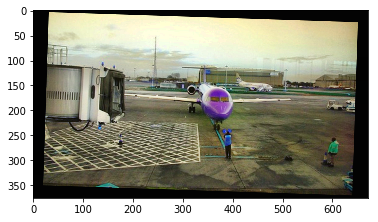

In [47]:
b, g, r = cv2.split(x[0].astype('uint8'))

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl_b = clahe.apply(b)
cl_g = clahe.apply(g)
cl_r = clahe.apply(r)
plt.imshow(cv2.merge((cl_b, cl_g, cl_r)))

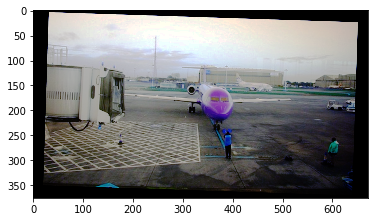

In [42]:
b, g, r = cv2.split(x[0].astype('uint8'))

cl_b = cv2.equalizeHist(b)
cl_g = cv2.equalizeHist(g)
cl_r = cv2.equalizeHist(r)

plt.imshow(cv2.merge((cl_b, cl_g, cl_r)))

In [14]:
cl1 = clahe.apply((x[0]).astype('uint8'))


error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/clahe.cpp:351: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'


In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)


In [5]:
x,y,s = next(iter(train_generator))

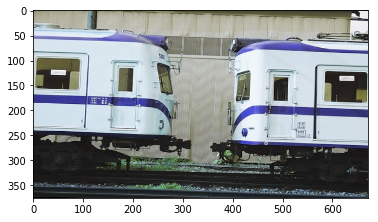

In [8]:
plt.imshow(x[2]/255)

In [5]:
pred = model.predict(x)

In [46]:
y_pred = tf.convert_to_tensor(pred)
y_true = tf.convert_to_tensor(y)

In [2]:
# build model
SegClass = SegModel(PATH, image_size, use_coords = False)
SegClass.set_batch_size(4)
SegClass.set_num_epochs(1)

#opt = SGD(momentum=0.9, decay=0.0005)
#opt = Adam(lr=1e-3, decay=0.995)
opt = RMSprop()
# tiramisu, segnet, unet, deeplab, mobileunet, enet

model = SegClass.create_seg_model(opt, net='mobileunet', load_weights = False, 
                                  multi_gpu = False, to_compile = True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv_0_bn (BatchNormalization)  (None, 112, 112, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
conv_0_relu (Activation)        (None, 112, 112, 32) 0           conv_0_bn[0][0]                  
__________________________________________________________________________________________________
conv_dw_1 

In [3]:
train_generator = SegClass.create_generators(data_trn_gen_args_image, data_trn_gen_args_mask, 
                                             subset = 'training', target_size = (512,512))
valid_generator = SegClass.create_generators(data_val_gen_args_image, data_val_gen_args_mask, 
                                             subset = 'validation', target_size = (512,512))

Found 10827 images belonging to 1 classes.
Found 10827 images belonging to 1 classes.
Found 1202 images belonging to 1 classes.
Found 1202 images belonging to 1 classes.


In [4]:
#data_trn_gen_args_image['preprocessing_function'] = None
#plt.imshow(np.reshape(np.argmax(y[0], axis=-1), image_size))
#show_aug_data(train_generator, data_trn_gen_args_image, data_trn_gen_args_mask)

In [4]:
h, cyclr = SegClass.train_generator(model, train_generator=train_generator,
                                    valid_generator = valid_generator,
                                    tf_board = False, mp = False)

Epoch 1/1
2706/2706 [==============================] - 2199s 813ms/step - loss: 2.3318 - Mean_IOU: 0.1321 - background_sparse_accuracy: 0.4683 - sparse_accuracy_ignoring_last_label: 0.4683 - foreground_sparse_accuracy: 0.6560 - val_loss: 2.2638 - val_Mean_IOU: 0.1811 - val_background_sparse_accuracy: 0.5738 - val_sparse_accuracy_ignoring_last_label: 0.5738 - val_foreground_sparse_accuracy: nan

Epoch 00001: val_loss improved from inf to 2.26385, saving model to weights/mobileunet.h5


In [5]:
x,y,z = next(valid_generator)
preds = np.argmax(model.predict(x), axis=-1)

In [6]:
p = np.reshape(preds, (4,224,224))
p.shape

(4, 224, 224)

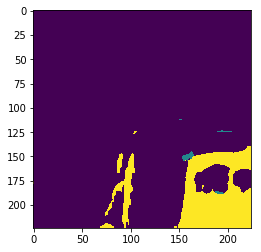

In [8]:
plt.imshow(p[3])

In [9]:
models_dir = './weights/'
model_filename = 'pc_big.pb'
convert_keras_to_pb(model, models_dir, model_filename)

INFO:tensorflow:Restoring parameters from ./saved_ckpt-0
INFO:tensorflow:Froze 190 variables.
INFO:tensorflow:Converted 190 variables to const ops.


In [10]:
[out.op.name for out in model.outputs]

['activation_1/truediv']

In [42]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, "weights", "pc2.pb", as_text=False)


INFO:tensorflow:Froze 456 variables.
INFO:tensorflow:Converted 456 variables to const ops.


'weights\\pc2.pb'

In [39]:
[out.op.name for out in model.outputs]

['activation_1/truediv']

Epoch 1/3
9000/9000 [==============================] - 38s 4ms/step - loss: 0.6978 - acc: 0.5032
Epoch 2/3
9000/9000 [==============================] - 37s 4ms/step - loss: 0.6940 - acc: 0.5158
Epoch 3/3
9000/9000 [==============================] - 37s 4ms/step - loss: 0.6938 - acc: 0.5120


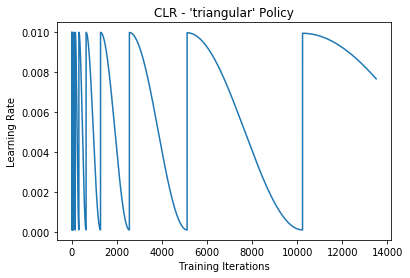

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input

inp = Input(shape=(15,))                
x = Dense(10, activation='relu')(inp)
x = Dense(1, activation='sigmoid')(x)

model = Model(inp, x)
X = np.random.rand(9000,15)
Y = np.random.randint(0,2,size=9000)
clr_triangular = CyclicLR(base_lr=0.0001, max_lr=0.01,
                      step_size=5, mode = 'cosine', gamma = 0.9999995,
                      scale_mode='iterations', cycle_mult = 2)

model.compile(optimizer=SGD(0.1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, Y, batch_size=2, nb_epoch=3, callbacks=[clr_triangular], verbose=1)
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])


### Freezing model

In [ ]:
#models_dir = './models/'
#model_filename = 'model_tf_{}x{}.pb'.format(image_size[0], image_size[1])
#convert_keras_to_pb(deeplab_model, models_dir, model_filename)


In [5]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in deeplab_model.outputs])
tf.train.write_graph(frozen_graph, "weights", "stack128.pb", as_text=False)


INFO:tensorflow:Froze 492 variables.
INFO:tensorflow:Converted 492 variables to const ops.


'weights\\stack128.pb'

#### Create Generators

In [ ]:
data_trn_gen_args_mask = dict(preprocessing_function = preprocess_mask,
                              horizontal_flip=True, rotation_range=45,
                              width_shift_range=0.01, 
                              height_shift_range=0.01,
                              zoom_range=0.2, 
                              validation_split = .2,
                              )

data_trn_gen_args_image = dict(preprocessing_function = preprocess_input,
                               horizontal_flip=True, rotation_range=45,
                               width_shift_range=0.01, 
                               height_shift_range=0.01,
                               zoom_range=0.2, 
                               validation_split = .2,
                               channel_shift_range = .2
                               )

data_val_gen_args_image = dict(preprocessing_function = preprocess_input, validation_split = .2)
data_val_gen_args_mask = dict(validation_split = .2)

train_generator = deeplab_seg.create_generators(data_trn_gen_args_image, data_trn_gen_args_mask, subset = 'training')
valid_generator = deeplab_seg.create_generators(data_val_gen_args_image, data_val_gen_args_mask, subset = 'validation')

In [ ]:
data_trn_gen_args_image['preprocessing_function'] = None

show_aug_data(train_generator, data_trn_gen_args_image, data_trn_gen_args_mask)

## Train Model

In [ ]:
h = deeplab_seg.train_generator(deeplab_model, train_generator=train_generator, 
                                valid_generator = valid_generator, 
                                tf_board = True, mp = True)

### EVALUATION

In [ ]:
classes = [c for c in get_VOC2012_classes().values()]
y_preds = deeplab_model.predict(X_test, batch_size = deeplab_seg.batch_size, verbose=1)
df_test, conf_test, mean_acc_test = evaluate_model(y_preds, y_test, data_from = 'test')

y_preds = deeplab_model.predict(X_valid, batch_size = deeplab_seg.batch_size, verbose=1)
df_valid, conf_valid, mean_acc_valid = evaluate_model(y_preds, y_valid, data_from = 'valid')
df_test['IoU valid'] = df_valid['IoU valid']

if deeplab_seg.coords:
    model_name = 'deeplabv3+ with added coordconv channels'
else:
    model_name = 'deeplabv3+'

plt.figure(figsize=(17,7))
plt.subplot(121)
plot_confusion_matrix(conf_test, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Test set. Model: '+model_name)
plt.subplot(122)
plot_confusion_matrix(conf_valid, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Validation set. Model: '+model_name)

print('test mean acc: ', mean_acc_test)
print('validation mean acc: ', mean_acc_valid)
df_test